In [1]:
import cv2
import os
import copy
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Models

In [2]:
import torchvision
m = torchvision.models.__dict__

# Data

In [3]:
image_dir = './data/Images'
train_path = './data/Train.csv'
test_path = './data/Test.csv'
pred_path = './submissions/ensemble_4x_resnet18.csv'

In [4]:
df = pd.read_csv(train_path)
df.head()

,Image_ID,Target
0,ID_0073qfb8,0
1,ID_00gy3vH2,1
2,ID_00uB3UFr,0
3,ID_012xZpNw,1
4,ID_014GgMRb,1


In [ ]:
test_df = pd.read_csv(test_path)
test_df.head()

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7000 entries, 0 to 6999
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Image_ID  7000 non-null   object
 1   Target    7000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 109.5+ KB


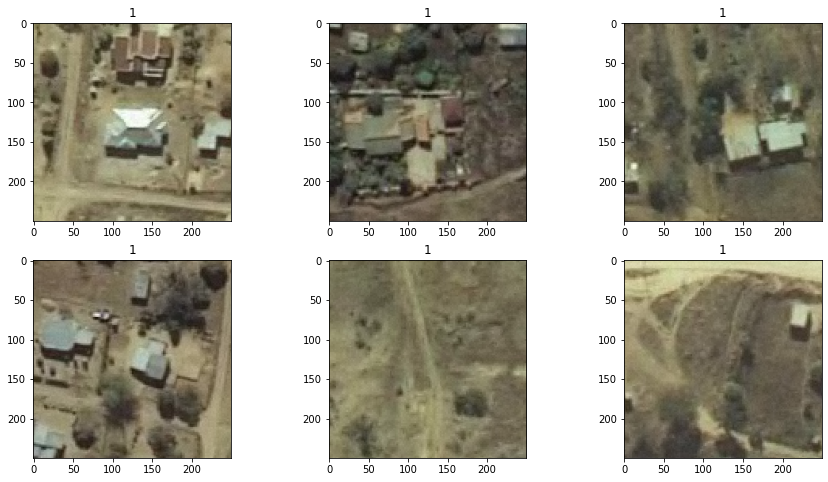

In [5]:
from utils import show_random

show_random(df, image_dir)

# Check augmentations

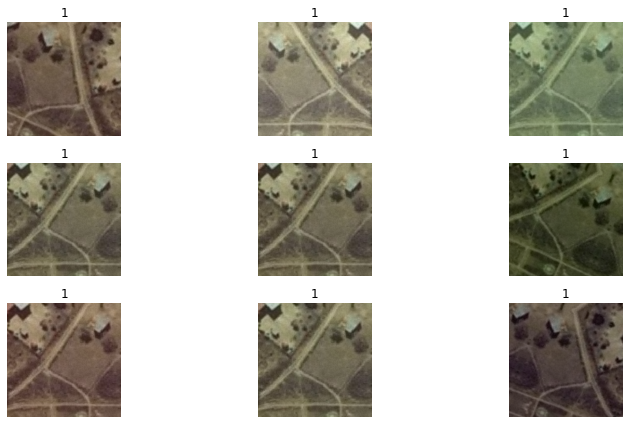

In [7]:
from dataset import RoadSegment
from utils import get_transform, visualize_augmentations

transforms = get_transform()
road_dataset = RoadSegment(df, image_dir, transforms['train'])
visualize_augmentations(road_dataset, idx=10)